In [1]:
import os
import sys
import json
import torch

sys.path.append("../")
from lib.utils import get_device
from lib.utils.constants import Subtask, Track, PreprocessTextLevel, DatasetType
from lib.utils.training import EarlyStopping
from lib.data.loading import load_train_dev_test_df, build_data_loader
from lib.data.tokenizer import get_tokenizer
from lib.models import get_model
from lib.training.loss import get_loss_fn
from lib.training.metric import get_metric
from lib.training.loops import training_loop, make_predictions

/Users/tmarchitan/Developer/ml_research/machine-generated_text_detection/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CONFIG_FILE_PATH = os.path.relpath("../config.json")

config = {}
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = json.load(config_file)

DEVICE = get_device()
print(f"Using device: {DEVICE}")

results_dir = os.path.relpath("../runs/SubtaskC")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

print(f"Will save results to: {results_dir}")

Using device: mps
Will save results to: ../runs/SubtaskC


In [5]:
config

{'task': 'SubtaskC',
 'submission_format': 'csv',
 'model': 'bilstm_crf_for_token_classification',
 'tokenizer': {'model_name': 'longformer',
  'pretrained_name': 'allenai/longformer-base-4096'},
 'data': {'dataset_type': 'token_classification_dataset',
  'dataset_type_settings': {'vocabulary_type': 'words'},
  'data_dir': './data/original_data',
  'label_column': 'label',
  'max_len': 1024,
  'batch_size': 16,
  'test_size': 0.2,
  'preprocess_text_level': 0},
 'model_config': {'embedding_dim': 50,
  'out_size': 2,
  'dropout_p': 0.6,
  'n_layers': 1,
  'hidden_dim': 32,
  'fc': [16]},
 'training': {'num_epochs': 15,
  'num_epochs_before_finetune': 3,
  'optimizer': {'AdamW': {'freeze_lr': 0.001, 'finetune_lr': 0.0001}},
  'early_stopping': {'patience': 10, 'delta': 0.0001},
  'scheduler': {'num_warmup_steps': 50},
  'loss': 'cross_entropy',
  'metric': 'mae'}}

In [11]:
task = None
if "task" in config:
    task = Subtask(config["task"])
else:
    raise ValueError("Task not specified in config")

track = None
if "track" in config:
    track = Track(config["track"])
else:
    print(f"Warning: Track not specified in config for subtask: {task}")

dataset_type = DatasetType.TransformerTruncationDataset
if "dataset_type" in config["data"]:
    dataset_type = DatasetType(config["data"]["dataset_type"])

dataset_type_settings = None
if "dataset_type_settings" in config["data"]:
    dataset_type_settings = config["data"]["dataset_type_settings"]

df_train, df_dev, df_test = load_train_dev_test_df(
    task=task,
    track=track,
    data_dir=f"../{config['data']['data_dir']}",
    label_column=config["data"]["label_column"],
    test_size=config["data"]["test_size"],
    preprocess_text_level=PreprocessTextLevel(
        config["data"]["preprocess_text_level"]
    ),
)

print(f"df_train.shape: {df_train.shape}")
print(f"df_dev.shape: {df_dev.shape}")
print(f"df_test.shape: {df_test.shape}")

Loading train data...
Train/dev split... (df_train.shape: (3649, 3))
Loading test data... ---> .././data/original_data/SubtaskC/SubtaskC_dev.jsonl
df_train.shape: (2919, 3)
df_dev.shape: (730, 3)
df_test.shape: (505, 3)


In [12]:
train_labels = df_train.label.values
dev_labels = df_dev.label.values
test_labels = df_test.label.values

In [13]:
min_train_label = train_labels.min()
max_train_label = train_labels.max()
mean_train_label = train_labels.mean()

print(f"min_train_label: {min_train_label}")
print(f"max_train_label: {max_train_label}")
print(f"mean_train_label: {mean_train_label}")

min_dev_label = dev_labels.min()
max_dev_label = dev_labels.max()
mean_dev_label = dev_labels.mean()

print(f"min_dev_label: {min_dev_label}")
print(f"max_dev_label: {max_dev_label}")
print(f"mean_dev_label: {mean_dev_label}")

min_test_label = test_labels.min()
max_test_label = test_labels.max()
mean_test_label = test_labels.mean()

print(f"min_test_label: {min_test_label}")
print(f"max_test_label: {max_test_label}")
print(f"mean_test_label: {mean_test_label}")

min_train_label: 0
max_train_label: 755
mean_train_label: 70.96197327852003
min_dev_label: 0
max_dev_label: 647
mean_dev_label: 73.43287671232876
min_test_label: 0
max_test_label: 467
mean_test_label: 68.52079207920792


In [9]:
label_column = config["data"]["label_column"]

if task == Subtask.SubtaskA:
    # Sample 1000 random examples from each dataset with respect to label
    df_train = df_train.sample(frac=1).groupby(label_column).head(500)
    df_dev = df_dev.sample(frac=1).groupby(label_column).head(500)
    df_test = df_test.sample(frac=1).groupby(label_column).head(500)
elif task == Subtask.SubtaskB:
    # Sample 1200 random examples from each dataset with respect to label
    df_train = df_train.sample(frac=1).groupby(label_column).head(200)
    df_dev = df_dev.sample(frac=1).groupby(label_column).head(200)
    df_test = df_test.sample(frac=1).groupby(label_column).head(200)
elif task == Subtask.SubtaskC:
    # Sample 500 random examples from each dataset
    df_train = df_train.sample(500)
    df_dev = df_dev.sample(500)
    df_test = df_test.sample(500)
else:
    raise ValueError(f"Unknown task: {task}")

In [10]:
print(f"df_train.shape: {df_train.shape}")
print(f"df_dev.shape: {df_dev.shape}")
print(f"df_test.shape: {df_test.shape}")

df_train.shape: (500, 3)
df_dev.shape: (500, 3)
df_test.shape: (500, 3)


In [14]:
tokenizer = get_tokenizer(**config["tokenizer"])

In [15]:
# Method to count number of tokens in each text given a pandas dataframe
def count_tokens(df):
    return df.text.apply(lambda x: len(tokenizer.tokenize(x))).values

train_counts = count_tokens(df_train)
dev_counts = count_tokens(df_dev)
test_counts = count_tokens(df_test)

min_train_count = train_counts.min()
max_train_count = train_counts.max()
mean_train_count = train_counts.mean()

print(f"min_train_count: {min_train_count}")
print(f"max_train_count: {max_train_count}")
print(f"mean_train_count: {mean_train_count}")

min_dev_count = dev_counts.min()
max_dev_count = dev_counts.max()
mean_dev_count = dev_counts.mean()

print(f"min_dev_count: {min_dev_count}")
print(f"max_dev_count: {max_dev_count}")
print(f"mean_dev_count: {mean_dev_count}")

min_test_count = test_counts.min()
max_test_count = test_counts.max()
mean_test_count = test_counts.mean()

print(f"min_test_count: {min_test_count}")
print(f"max_test_count: {max_test_count}")
print(f"mean_test_count: {mean_test_count}")

min_train_count: 26
max_train_count: 1420
mean_train_count: 300.7677286742035
min_dev_count: 28
max_dev_count: 1709
mean_dev_count: 312.23424657534247
min_test_count: 35
max_test_count: 1137
mean_test_count: 298.58217821782176


/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_74195/2379846218.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_counts, ax=ax, label="train")
/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_74195/2379846218.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dev

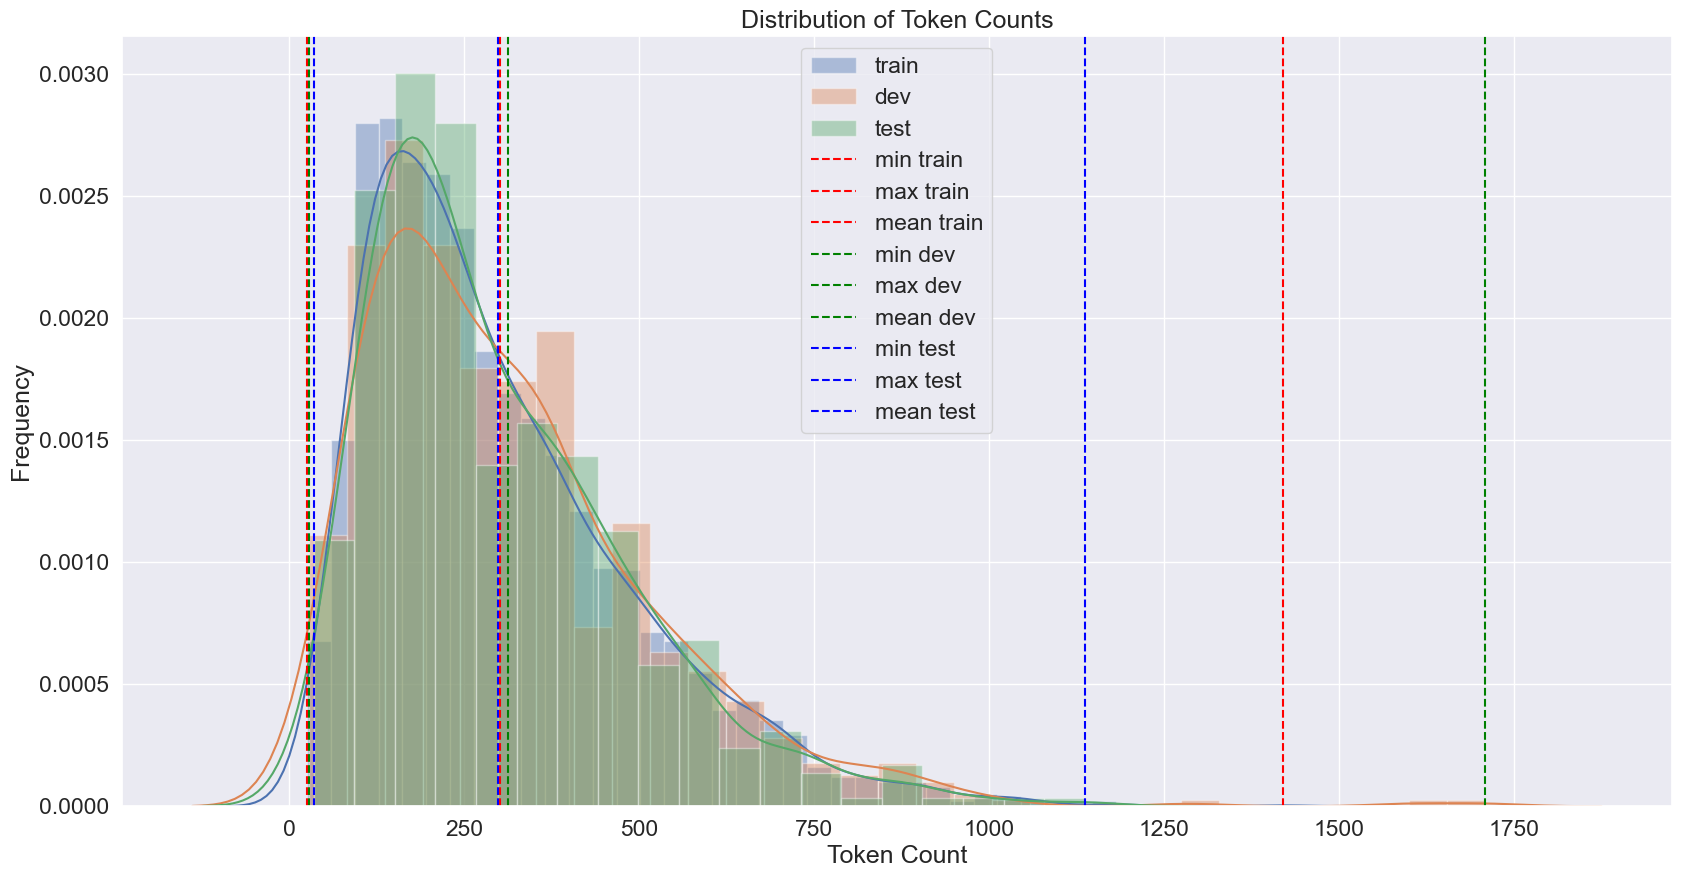

In [16]:
# Plot histogram of token counts for each dataset and point out the min, max, and mean
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train_counts, ax=ax, label="train")
sns.distplot(dev_counts, ax=ax, label="dev")
sns.distplot(test_counts, ax=ax, label="test")

ax.axvline(min_train_count, color="red", linestyle="--", label="min train")
ax.axvline(max_train_count, color="red", linestyle="--", label="max train")
ax.axvline(mean_train_count, color="red", linestyle="--", label="mean train")

ax.axvline(min_dev_count, color="green", linestyle="--", label="min dev")
ax.axvline(max_dev_count, color="green", linestyle="--", label="max dev")
ax.axvline(mean_dev_count, color="green", linestyle="--", label="mean dev")

ax.axvline(min_test_count, color="blue", linestyle="--", label="min test")  # long dash with offset
ax.axvline(max_test_count, color="blue", linestyle="--", label="max test")
ax.axvline(mean_test_count, color="blue", linestyle="--", label="mean test")

ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Token Counts")
ax.legend()

plt.savefig("../plots/tokens_distribution.png")
plt.show()

/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_64540/1647743751.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_counts, ax=ax, label="train")
/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_64540/1647743751.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dev

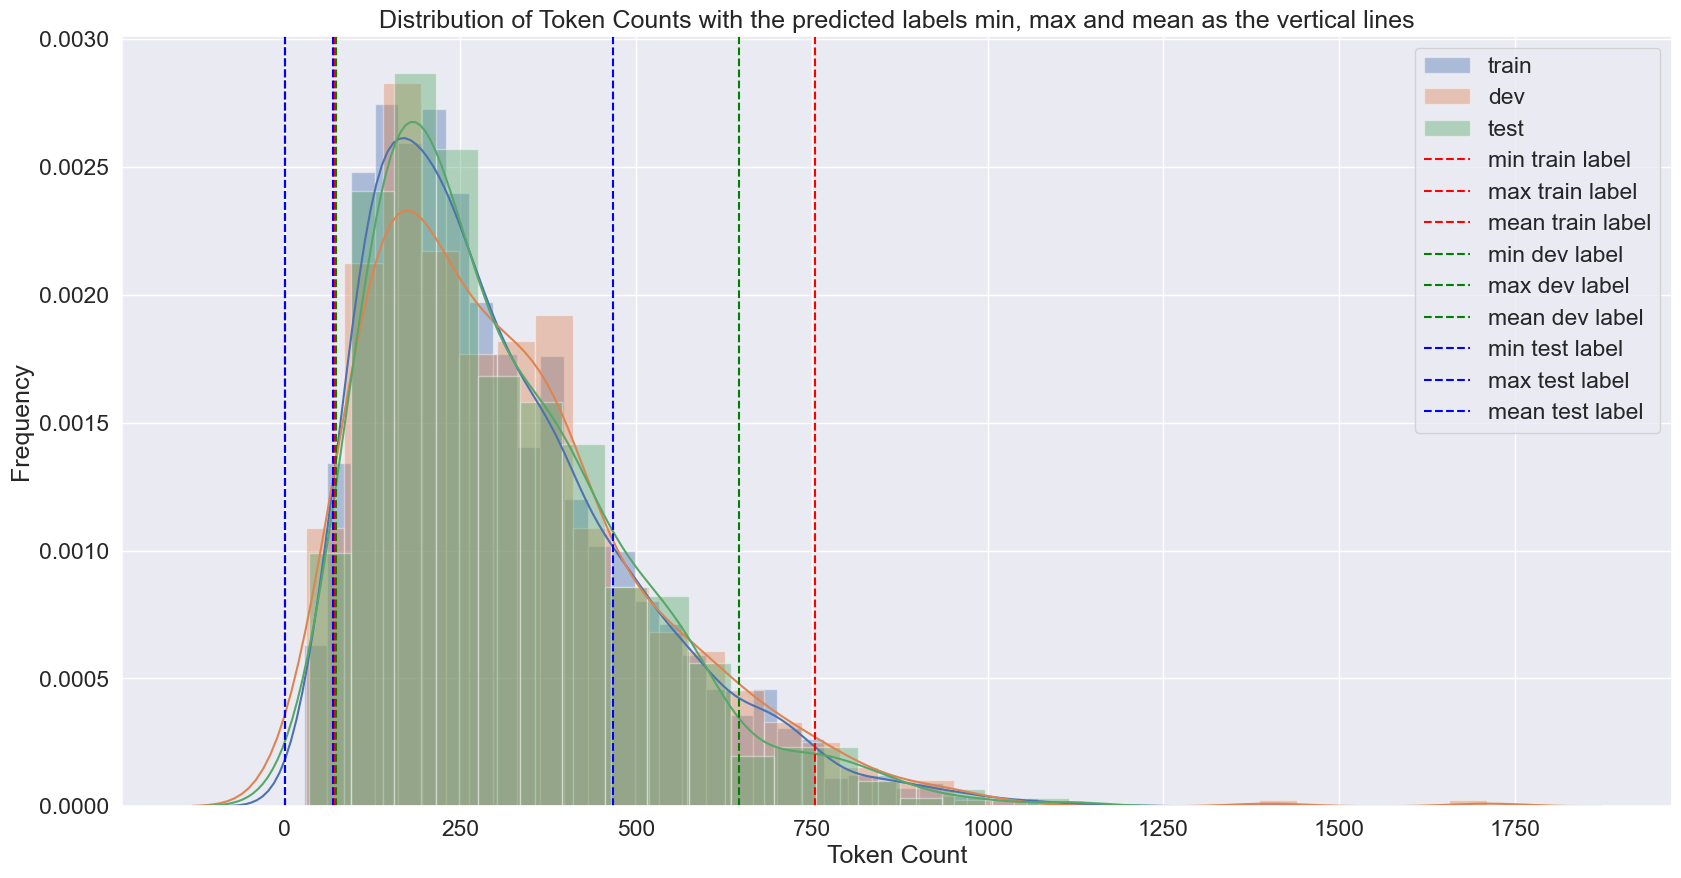

In [46]:
# Plot histogram of token counts for each dataset and point out the min, max, and mean
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train_counts, ax=ax, label="train")
sns.distplot(dev_counts, ax=ax, label="dev")
sns.distplot(test_counts, ax=ax, label="test")

ax.axvline(min_train_label, color="red", linestyle="--", label="min train label")
ax.axvline(max_train_label, color="red", linestyle="--", label="max train label")
ax.axvline(mean_train_label, color="red", linestyle="--", label="mean train label")

ax.axvline(min_dev_label, color="green", linestyle="--", label="min dev label")
ax.axvline(max_dev_label, color="green", linestyle="--", label="max dev label")
ax.axvline(mean_dev_label, color="green", linestyle="--", label="mean dev label")

ax.axvline(min_test_label, color="blue", linestyle="--", label="min test label")
ax.axvline(max_test_label, color="blue", linestyle="--", label="max test label")
ax.axvline(mean_test_label, color="blue", linestyle="--", label="mean test label")

ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Token Counts with the predicted labels min, max and mean as the vertical lines")
ax.legend()

plt.savefig("../plots/tokens_distribution_with_predicted_labels.png")
plt.show()

In [53]:
train_dataloader = build_data_loader(
    df_train,
    tokenizer,
    max_len=config["data"]["max_len"],
    batch_size=config["data"]["batch_size"],
    label_column=config["data"]["label_column"],
    shuffle=True,
    dataset_type=dataset_type,
    dataset_type_settings=dataset_type_settings,
    device=DEVICE,
)
dev_dataloader = build_data_loader(
    df_dev,
    tokenizer,
    max_len=config["data"]["max_len"],
    batch_size=config["data"]["batch_size"],
    label_column=config["data"]["label_column"],
    dataset_type=dataset_type,
    dataset_type_settings=dataset_type_settings,
    device=DEVICE,
)
test_dataloader = build_data_loader(
    df_test,
    tokenizer,
    max_len=config["data"]["max_len"],
    batch_size=config["data"]["batch_size"],
    label_column=config["data"]["label_column"],
    has_targets=False if config["data"]["test_size"] is None else True,
    dataset_type=dataset_type,
    dataset_type_settings=dataset_type_settings,
    device=DEVICE,
)

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


Will tokenize long texts (may take a while)...

---- Done tokenizing long texts ----

Will tokenize long texts (may take a while)...

---- Done tokenizing long texts ----

Will tokenize long texts (may take a while)...

---- Done tokenizing long texts ----



In [54]:
num_epochs = config["training"]["num_epochs"]
model = get_model(config["model"], config["model_config"]).to(DEVICE)
loss_fn = get_loss_fn(config["training"]["loss"], DEVICE)
optimizer_config = config["training"]["optimizer"]
scheduler_config = config["training"]["scheduler"]
metric_fn, is_better_metric_fn = get_metric(config["training"]["metric"])
num_epochs_before_finetune = config["training"]["num_epochs_before_finetune"]
swa_config = config["training"]["swa"] if "swa" in config["training"] else None
validation_freq = (
    config["training"]["validation_freq"]
    if "validation_freq" in config["training"] else None
)
early_stopping = None
if "early_stopping" in config["training"]:
    early_stopping = EarlyStopping(
        path=results_dir,
        verbose=True,
        **config["training"]["early_stopping"],
    )

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print(f"Will use early stopping: {early_stopping is not None}")

best_model = training_loop(
    model,
    num_epochs,
    train_dataloader,
    dev_dataloader,
    loss_fn,
    optimizer_config,
    scheduler_config,
    DEVICE,
    metric_fn,
    is_better_metric_fn,
    results_dir,
    num_epochs_before_finetune,
    early_stopping=early_stopping,
    swa_config=swa_config,
    validation_freq=validation_freq,
    fabric=None,
)

Will use early stopping: True
Epoch 1/10
Freeze transformeer
--------------------
Batch=[1/150]; Loss=[1.80626]; Acc. Metric=0.125; Elapsed time=0.13s [00:00:00.13]
Batch=[101/150]; Loss=[1.90174]; Acc. Metric=0.0; Elapsed time=8.29s [00:00:08.29]
Train Loss: 1.80632; Train Metric: 0.21333; Elapsed time=12.30s [00:00:12.30]


100%|██████████| 150/150 [00:10<00:00, 14.25it/s]


Validation Loss: 1.63202; Validation Metric: 0.31500
Validation loss decreased (inf --> 1.632019).  Saving model to ./early_stopping_best_model.bin...
Epoch 2/10
Freeze transformeer
--------------------
Batch=[1/150]; Loss=[1.65091]; Acc. Metric=0.25; Elapsed time=0.09s [00:00:00.09]
Batch=[101/150]; Loss=[1.50467]; Acc. Metric=0.5; Elapsed time=7.88s [00:00:07.88]
Train Loss: 1.62245; Train Metric: 0.31000; Elapsed time=11.87s [00:00:11.87]


100%|██████████| 150/150 [00:10<00:00, 14.33it/s]


Validation Loss: 1.62881; Validation Metric: 0.31583
Validation loss decreased (1.632019 --> 1.628807).  Saving model to ./early_stopping_best_model.bin...
Epoch 3/10
Freeze transformeer
--------------------
Batch=[1/150]; Loss=[1.09735]; Acc. Metric=0.375; Elapsed time=0.08s [00:00:00.08]
Batch=[101/150]; Loss=[1.39092]; Acc. Metric=0.375; Elapsed time=7.86s [00:00:07.86]
Train Loss: 1.52217; Train Metric: 0.37500; Elapsed time=11.86s [00:00:11.86]


100%|██████████| 150/150 [00:10<00:00, 14.30it/s]


Validation Loss: 1.53702; Validation Metric: 0.36500
Validation loss decreased (1.628807 --> 1.537023).  Saving model to ./early_stopping_best_model.bin...
Epoch 4/10
Freeze transformeer
--------------------
Batch=[1/150]; Loss=[1.45719]; Acc. Metric=0.5; Elapsed time=0.08s [00:00:00.08]
Batch=[101/150]; Loss=[1.08708]; Acc. Metric=0.375; Elapsed time=7.84s [00:00:07.84]
Train Loss: 1.44511; Train Metric: 0.40750; Elapsed time=11.85s [00:00:11.85]


100%|██████████| 150/150 [00:10<00:00, 14.32it/s]


Validation Loss: 1.53011; Validation Metric: 0.37750
Validation loss decreased (1.537023 --> 1.530105).  Saving model to ./early_stopping_best_model.bin...
Epoch 5/10
Freeze transformeer
--------------------
Batch=[1/150]; Loss=[1.51204]; Acc. Metric=0.125; Elapsed time=0.08s [00:00:00.08]
Batch=[101/150]; Loss=[1.84234]; Acc. Metric=0.125; Elapsed time=7.91s [00:00:07.91]
Train Loss: 1.44907; Train Metric: 0.40500; Elapsed time=11.85s [00:00:11.85]


100%|██████████| 150/150 [00:10<00:00, 14.29it/s]


Validation Loss: 1.49370; Validation Metric: 0.38250
Validation loss decreased (1.530105 --> 1.493704).  Saving model to ./early_stopping_best_model.bin...
Epoch 6/10
Finetune transformer
--------------------
Batch=[1/150]; Loss=[1.27431]; Acc. Metric=0.5; Elapsed time=0.08s [00:00:00.08]
Batch=[101/150]; Loss=[0.85564]; Acc. Metric=0.875; Elapsed time=9.22s [00:00:09.22]
Train Loss: 1.31481; Train Metric: 0.47667; Elapsed time=13.67s [00:00:13.67]


100%|██████████| 150/150 [00:10<00:00, 14.36it/s]


Validation Loss: 1.46815; Validation Metric: 0.40083
Validation loss decreased (1.493704 --> 1.468154).  Saving model to ./early_stopping_best_model.bin...
Epoch 7/10
Finetune transformer
--------------------
Batch=[1/150]; Loss=[1.73325]; Acc. Metric=0.125; Elapsed time=0.08s [00:00:00.08]
Batch=[101/150]; Loss=[1.52264]; Acc. Metric=0.375; Elapsed time=8.94s [00:00:08.94]
Train Loss: 1.22573; Train Metric: 0.51417; Elapsed time=13.41s [00:00:13.41]


100%|██████████| 150/150 [00:10<00:00, 14.34it/s]


Validation Loss: 1.48346; Validation Metric: 0.41500
EarlyStopping: counter = 1 out of 2
Epoch 8/10
Finetune transformer
--------------------
Batch=[1/150]; Loss=[1.52158]; Acc. Metric=0.375; Elapsed time=0.10s [00:00:00.10]
Batch=[101/150]; Loss=[1.37114]; Acc. Metric=0.625; Elapsed time=8.98s [00:00:08.98]
Train Loss: 1.10689; Train Metric: 0.58250; Elapsed time=13.41s [00:00:13.41]


100%|██████████| 150/150 [00:10<00:00, 14.34it/s]


Validation Loss: 1.55724; Validation Metric: 0.41750
EarlyStopping: counter = 2 out of 2
Early stopping


In [26]:
make_predictions(
    best_model,
    test_dataloader,
    DEVICE,
    results_dir,
    label_column=config["data"]["label_column"],
    file_format=config["submission_format"],
)

100%|██████████| 150/150 [00:09<00:00, 15.19it/s]


,id,true,label
0,14345,5.0,3
1,2269,1.0,1
2,2236,1.0,2
3,14223,5.0,2
4,7524,3.0,2
...,...,...,...
1195,5100,0.0,0
1196,4760,0.0,1
1197,14535,5.0,2
1198,14237,5.0,1


In [47]:
early_stopping_model = model
early_stopping_model.load_state_dict(
    torch.load(os.path.join(results_dir, "early_stopping_best_model.bin"))
)

make_predictions(
    early_stopping_model,
    test_dataloader,
    DEVICE,
    results_dir,
    label_column=config["data"]["label_column"],
    file_format=config["submission_format"],
)

100%|██████████| 150/150 [00:09<00:00, 15.42it/s]


,id,true,label
0,14345,5.0,0
1,2269,1.0,1
2,2236,1.0,2
3,14223,5.0,2
4,7524,3.0,1
...,...,...,...
1195,5100,0.0,0
1196,4760,0.0,0
1197,14535,5.0,2
1198,14237,5.0,1


In [33]:
# best_model results
!python ../scores_and_plots.py --results-dir "../runs/SubtaskB"

Results on validation
Accuracy: 41.75%
Precision: 49.45%
Recall: 41.75%
F1: 40.50%
--------------------
Results on test
Accuracy: 36.42%
Precision: 46.44%
Recall: 36.42%
F1: 33.47%
--------------------


In [48]:
# early_stopping_model results
!python ../scores_and_plots.py --results-dir "../runs/SubtaskB"

Results on validation
Accuracy: 41.75%
Precision: 49.45%
Recall: 41.75%
F1: 40.50%
--------------------
Results on test
Accuracy: 38.42%
Precision: 49.82%
Recall: 38.42%
F1: 34.00%
--------------------
